<a href="https://www.kaggle.com/code/makitdev/spaceship-titanic-fastai-ensemble?scriptVersionId=104808156" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.tabular.all import *
from bayes_opt import BayesianOptimization

set_seed(42, True)
np.random.seed(42)

In [2]:
# Import the datasets
path = Path('/kaggle/input/spaceship-titanic')
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [3]:
# View the data
train_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


# Tidy the Data

In [5]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
# If null then make them 0 as they spent nothing.
def fill_billed_with_zero(df):
    df['RoomService'] = df.RoomService.fillna(0)
    df['FoodCourt'] = df.FoodCourt.fillna(0)
    df['ShoppingMall'] = df.ShoppingMall.fillna(0)
    df['Spa'] = df.Spa.fillna(0)
    df['VRDeck'] = df.VRDeck.fillna(0)
    
fill_billed_with_zero(train_df)
fill_billed_with_zero(test_df)

In [7]:
# If not True for VIP then default to false
def fill_vip(df):
    df['VIP'] = df.VIP.fillna(False)
    
fill_vip(train_df)
fill_vip(test_df)

In [8]:
# If they have spent something then CryoSleep must be true
def fill_cryo_with_false(df):
    df['CryoSleep'] = np.where((df.CryoSleep.isnull()) & 
                               ((df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck) == 0), True, df.CryoSleep)
    df['CryoSleep'] = np.where((df.CryoSleep.isnull()) & 
                               ((df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck) != 0), False, df.CryoSleep)
    
fill_cryo_with_false(train_df)
fill_cryo_with_false(test_df)

# Interesting Data
## PassengerId

A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

*Splitting out the group to a new column could show something interesting*

## Cabin

The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

*Splitting deck and side out as it's own value could show something*

## Name

Gut feeling is that this is pointless, but data will see. Maybe correlation with surname for family groups.

## Expenditure

Data seems to show a lot of people who spent nothing, new feature for that?

## Solo people

Some people are "solo" - new feature?

In [9]:
# Create the Group ID column
def create_group_id(df):
    df[['GroupId','PassengerNum']] = df.PassengerId.str.split('_', expand=True)
    df['GroupId'] = df.GroupId.astype('int')
    df['PassengerNum'] = df.PassengerNum.astype('int')
    
create_group_id(train_df)
create_group_id(test_df)

train_df.drop(['PassengerId'], axis=1, inplace=True)

In [10]:
# With such a small dataset, the name makes it overfit
train_df.drop(['Name'], axis=1, inplace=True)
test_df.drop(['Name'], axis=1, inplace=True)

In [11]:
# Create the Deck Column
def create_deck(df):
    df[['CabinDeck','CabinNum', 'CabinSide']] = df.Cabin.str.split('/', expand=True)
    df['CabinNum'] = df.CabinNum.astype('float')
    df.drop(['Cabin'], axis=1, inplace=True)
    
create_deck(train_df)
create_deck(test_df)

In [12]:
def convert_to_dummies(df):
    df = pd.get_dummies(df, columns=['Destination'], prefix="D")
    df = pd.get_dummies(df, columns=['HomePlanet'], prefix="H")
    df = pd.get_dummies(df, columns=['CabinSide'])
    df = pd.get_dummies(df, columns=['VIP'])
    df = pd.get_dummies(df, columns=['CryoSleep'])
    df = pd.get_dummies(df, columns=['CabinDeck'])
    return df
    
train_df = convert_to_dummies(train_df)
test_df = convert_to_dummies(test_df)

In [13]:
# Check data types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              8514 non-null   float64
 1   RoomService      8693 non-null   float64
 2   FoodCourt        8693 non-null   float64
 3   ShoppingMall     8693 non-null   float64
 4   Spa              8693 non-null   float64
 5   VRDeck           8693 non-null   float64
 6   Transported      8693 non-null   bool   
 7   GroupId          8693 non-null   int64  
 8   PassengerNum     8693 non-null   int64  
 9   CabinNum         8494 non-null   float64
 10  D_55 Cancri e    8693 non-null   uint8  
 11  D_PSO J318.5-22  8693 non-null   uint8  
 12  D_TRAPPIST-1e    8693 non-null   uint8  
 13  H_Earth          8693 non-null   uint8  
 14  H_Europa         8693 non-null   uint8  
 15  H_Mars           8693 non-null   uint8  
 16  CabinSide_P      8693 non-null   uint8  
 17  CabinSide_S   

In [14]:
# View the data again to check the changes
train_df

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,PassengerNum,CabinNum,...,CryoSleep_False,CryoSleep_True,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T
0,39.0,0.0,0.0,0.0,0.0,0.0,False,1,1,0.0,...,1,0,0,1,0,0,0,0,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,2,1,0.0,...,1,0,0,0,0,0,0,1,0,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,3,1,0.0,...,1,0,1,0,0,0,0,0,0,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,3,2,0.0,...,1,0,1,0,0,0,0,0,0,0
4,16.0,303.0,70.0,151.0,565.0,2.0,True,4,1,1.0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,False,9276,1,98.0,...,1,0,1,0,0,0,0,0,0,0
8689,18.0,0.0,0.0,0.0,0.0,0.0,False,9278,1,1499.0,...,0,1,0,0,0,0,0,0,1,0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,True,9279,1,1500.0,...,1,0,0,0,0,0,0,0,1,0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,False,9280,1,608.0,...,1,0,0,0,0,0,1,0,0,0


In [15]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,PassengerNum,CabinNum,D_55 Cancri e,...,CryoSleep_False,CryoSleep_True,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T
count,8514.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8494.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.827930,220.009318,448.434027,169.572300,304.588865,298.261820,4633.389624,1.517773,600.367671,0.207063,...,0.639365,0.360635,0.029449,0.089612,0.085931,0.054987,0.100771,0.321408,0.294375,0.000575
std,14.489021,660.519050,1595.790627,598.007164,1125.562559,1134.126417,2671.028856,1.054241,511.867226,0.405224,...,0.480212,0.480212,0.169071,0.285642,0.280279,0.227968,0.301042,0.467044,0.455787,0.023977
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2319.000000,1.000000,167.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4630.000000,1.000000,427.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,41.000000,61.000000,22.000000,53.000000,40.000000,6883.000000,2.000000,999.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,9280.000000,8.000000,1894.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Create the Model

In [16]:
cont_names, cat_names = cont_cat_split(train_df, dep_var="Transported")

In [17]:
dls = TabularPandas(
    train_df,
    y_names="Transported", 
    y_block = CategoryBlock(),
    cat_names = cat_names,
    cont_names = cont_names,
    splits=RandomSplitter(valid_pct=0.2)(train_df),
    procs = [Categorify, Normalize, FillMissing]).dataloaders(bs=128)

In [18]:
dls.show_batch()

,PassengerNum,D_55 Cancri e,D_PSO J318.5-22,D_TRAPPIST-1e,H_Earth,H_Europa,H_Mars,CabinSide_P,CabinSide_S,VIP_False,VIP_True,CryoSleep_False,CryoSleep_True,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,Age_na,CabinNum_na,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,CabinNum,Transported
0,4,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,False,False,61.0,0.000007,4.082000e+03,-9.631443e-07,265.000000,200.999998,3353.000014,124.999990,True
1,2,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,False,False,6.0,0.000007,5.882305e-07,-9.631443e-07,0.000010,-0.000008,6774.000079,1099.999995,False
2,1,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,False,False,61.0,2.000010,5.882305e-07,1.699999e+01,868.000015,28.000002,2135.999935,343.000001,False
3,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,False,False,20.0,0.000007,5.882305e-07,-9.631443e-07,0.000010,-0.000008,4437.000006,724.999998,True
4,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,False,False,33.0,0.000007,3.799999e+01,-9.631443e-07,0.999992,3166.999927,6364.999973,63.999995,False
5,1,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,False,False,18.0,0.000007,5.882305e-07,-9.631443e-07,0.000010,-0.000008,5823.000017,944.000000,True
6,2,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,False,False,29.0,0.000007,5.882305e-07,-9.631443e-07,0.000010,-0.000008,4981.000002,814.000004,True
7,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,False,False,38.0,0.000007,5.882305e-07,-9.631443e-07,0.000010,-0.000008,6446.999978,1042.999995,True
8,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,False,False,34.0,0.000007,5.882305e-07,-9.631443e-07,0.000010,-0.000008,1267.000117,190.999987,True
9,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,False,False,22.0,664.000017,5.882305e-07,-9.631443e-07,65.000001,-0.000008,3061.000075,638.000000,False


In [19]:
learn = tabular_learner(dls, 
                        metrics=[accuracy, error_rate], 
                        layers=[170, 100])

SuggestedLRs(slide=0.033113110810518265, valley=0.0006918309954926372)

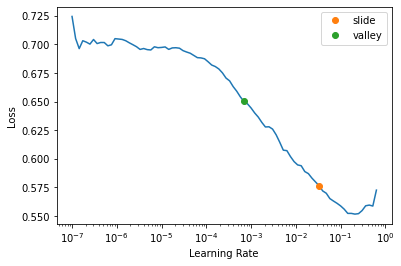

In [20]:
# Find a good learning rate
learn.lr_find(suggest_funcs=(slide, valley))

In [21]:
learn.fit_one_cycle(10, 0.01)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.487625,0.472349,0.765247,0.234753,00:00
1,0.443328,0.448481,0.795167,0.204833,00:00
2,0.425349,0.431280,0.798619,0.201381,00:00
3,0.412539,0.423421,0.792865,0.207135,00:00
4,0.402406,0.421108,0.794016,0.205984,00:00
5,0.391623,0.407471,0.801496,0.198504,00:00
6,0.382983,0.396144,0.810702,0.189298,00:00
7,0.372526,0.397146,0.810702,0.189298,00:01
8,0.360153,0.400354,0.808400,0.191600,00:00
9,0.350477,0.395966,0.813579,0.186421,00:00


In [22]:
learn.summary()

TabularModel (Input shape: 128 x 23)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 5             
Embedding                                 45         True      
____________________________________________________________________________
                     128 x 3             
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                         

In [23]:
learn.show_results()

,PassengerNum,D_55 Cancri e,D_PSO J318.5-22,D_TRAPPIST-1e,H_Earth,H_Europa,H_Mars,CabinSide_P,CabinSide_S,VIP_False,VIP_True,CryoSleep_False,CryoSleep_True,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,Age_na,CabinNum_na,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,CabinNum,Transported,Transported_pred
0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,-0.056839,2.317650,-0.283400,-0.184100,-0.267988,-0.263122,1.236919,2.079575,0.0,0.0
1,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,-0.752327,1.356716,-0.284032,-0.280746,0.934879,-0.086803,-0.771029,-0.192158,0.0,0.0
2,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.474132,-0.327109,7.037747,-0.280746,8.479906,-0.262217,0.386842,-0.748219,0.0,0.0
3,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,-0.613229,0.722908,-0.284032,-0.263791,-0.267988,-0.263122,-0.209297,0.482633,0.0,0.0
4,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.638649,-0.327109,-0.278980,0.967174,-0.148470,-0.263122,-1.489463,-0.985682,0.0,0.0
5,3.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,-0.404583,1.473547,-0.284032,0.612806,-0.267988,-0.263122,0.666586,1.454255,0.0,0.0
6,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.847295,0.251204,-0.284032,0.826444,-0.267988,-0.263122,1.352856,-0.130814,0.0,0.0
7,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,-0.752327,0.635285,-0.284032,3.646134,-0.267988,-0.242325,-0.264648,-0.653233,1.0,0.0
8,4.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.682778,-0.327109,-0.284032,-0.280746,-0.267988,-0.263122,0.773547,-1.045048,1.0,1.0


In [24]:
# Run the predictions
tst_dl = learn.dls.test_dl(test_df)
preds,_ = learn.get_preds(dl=tst_dl)

# Ensemble

In [25]:
def ensemble():
    learn = tabular_learner(dls, metrics=[accuracy, error_rate], layers=[170,100])
    with learn.no_bar(),learn.no_logging(): learn.fit(10, lr=0.01)
    return learn.get_preds(dl=tst_dl)[0]

In [26]:
learns = [ensemble() for _ in range(20)]

In [27]:
# Stack and average
ens_preds = torch.stack(learns).mean(0)

# Submission

In [28]:
# Create the submission file
test_df['Transported'] = (ens_preds[:,1]>0.5)
sub_df = test_df[['PassengerId','Transported']]

In [29]:
sub_df

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [30]:
sub_df.to_csv('submission.csv', index=False)